# Objective #1

In [4]:
from itertools import product
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree, linear_model
from sklearn.metrics import *

In [5]:
df = pd.read_csv("parkinsons_updrs.data")
n, m = df.shape

## 1.0. Data sett inspection

['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


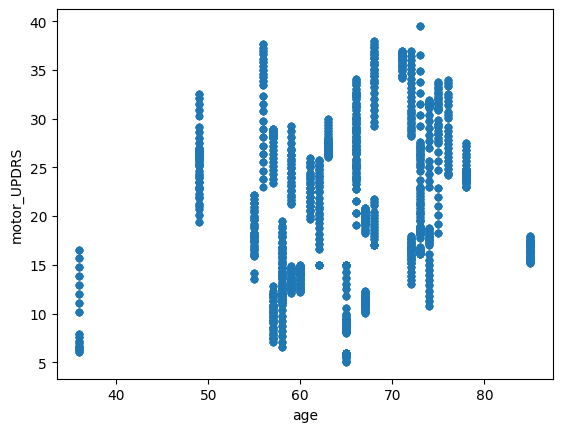

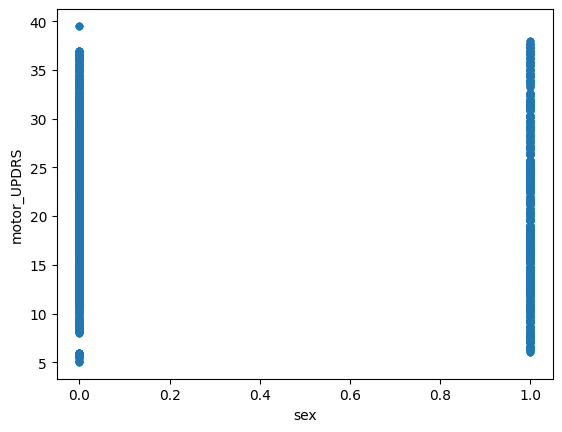

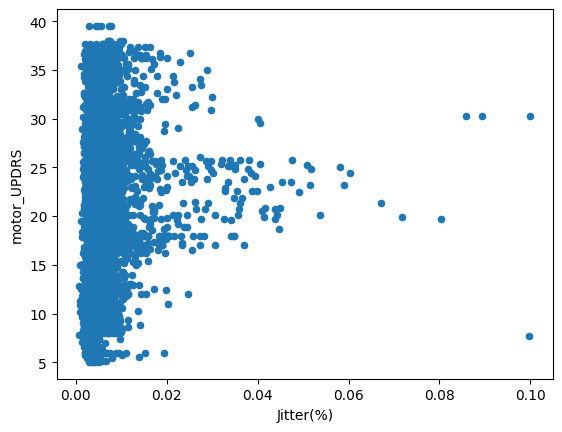

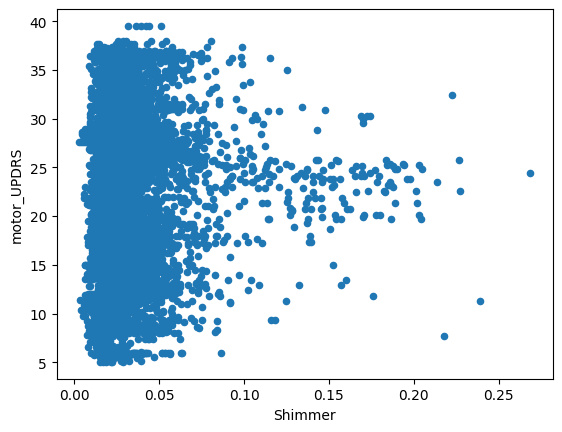

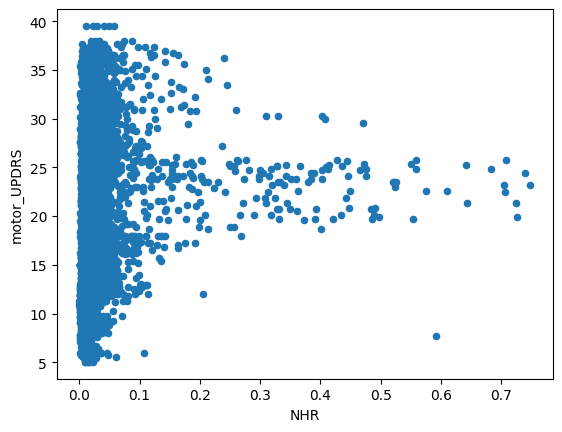

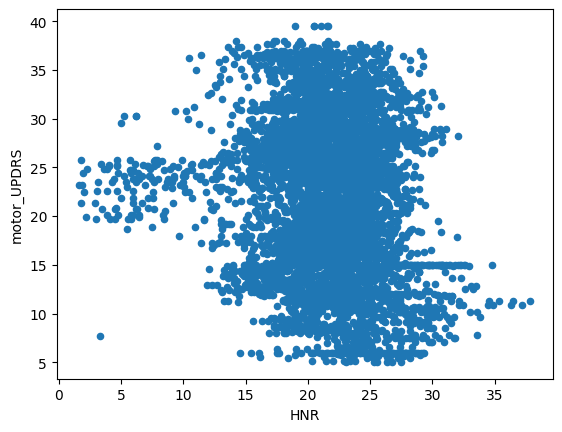

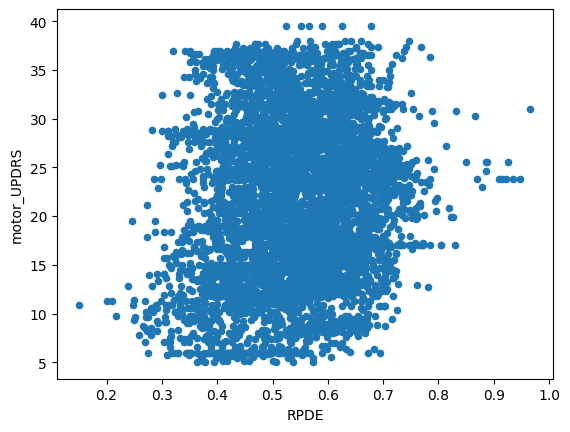

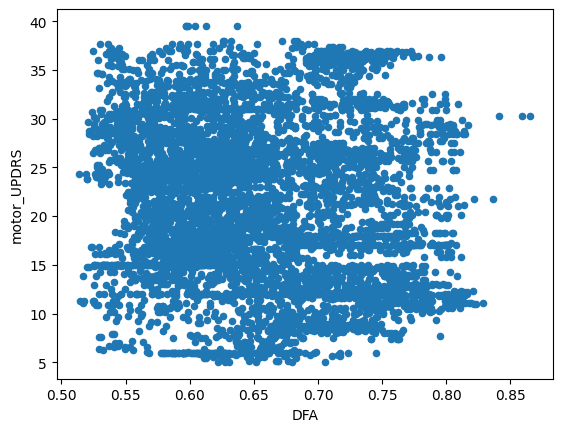

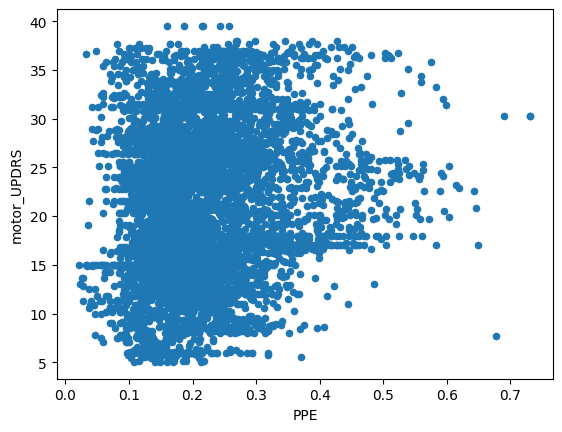

In [6]:
columns = list(df.columns.values)
print(columns)
x_columns = columns[6:]
for x_col in ['age', 'sex', 'Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']:
    df.plot.scatter(x=x_col, y="motor_UPDRS")


## 1.1. Dataset preparation
### 1.1.1. Shuffle and Split into training and IVS
- `train_df` -- training set for model training/selection
- `ivs_df` -- independet validation set (IVS) for the final benchmark

In [7]:
df = df.sample(frac=1)
train_size = int(0.8 * n)
train_df = df.iloc[:train_size]
ivs_df = df.iloc[train_size:]

In [123]:
#train_x = np.array(train_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_x = np.array(train_df[['age', 'sex', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_y = np.array(train_df["motor_UPDRS"])

#ivs_x = np.array(ivs_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_x = np.array(ivs_df[['age', 'sex', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_y = np.array(ivs_df["motor_UPDRS"])

### 1.1.2. Scale data

In [124]:
x_mean  = np.mean(train_x, axis=0)
x_std   = np.std(train_x, axis=0)
train_x = (train_x - x_mean) / x_std
y_mean  = np.mean(train_y, axis=0)
y_std  = np.std(train_y, axis=0)
train_y = (train_y - y_mean) / y_std
ivs_x_scaled = (ivs_x - np.mean(ivs_x, axis=0)) / np.std(ivs_x, axis=0)
ivs_y_scaled   = (ivs_y - np.mean(ivs_y, axis=0)) / np.std(ivs_y, axis=0)

### 1.2.Validation techniques (shared for regression and classification)

In [125]:
def simple_cross_validation(*, model, x, y, train_partition=(0, 0.8), metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    
    start = int(train_partition[0] * n)
    end = int(train_partition[1] * n)
    
    x_train = x[start:end, :]
    y_train = y[start:end]
    x_test = np.concatenate((x[:start, :], x[end:, :]))
    y_test = np.concatenate((y[:start], y[end:]))
    
    #print("SCV")
    #print(x_train)
    #print(y_train)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return {metric_name: metric_f(y_test, y_pred) for (metric_name, metric_f) in metrics.items()}


def kfold(*, model, x, y, k=5, metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    results = {metric: 0 for metric in metrics.keys()}
    
    for i in range(k):
        start = i * (1/k)
        end = start + (1/k)
        if (i + 1) == k:
            end = 1.0
            
        iteration_results = simple_cross_validation(model=model, x=x, y=y, train_partition=(start, end), metrics=metrics)
        
        for metric in metrics.keys():
            results[metric] += iteration_results[metric]
    
    for metric in results.keys():
        results[metric] /= k
    
    return results

### 1.3. Model Selection

In [126]:
def results2df(hyperparams_names, hyperparams_values, results, metrics):
    if len(hyperparams_names) > 1:
        index = pd.MultiIndex.from_tuples(hyperparams_values, names=hyperparams_names)
    else:
        index = pd.Index(hyperparams_values, name=hyperparams_names[0])
    data = [[m for m in v["evaluation"].values()] for v in results.values()]
    results = pd.DataFrame(data, index=index, columns=metrics.keys())
    results = results.style.format({m: '{:.3f}' for m in metrics.keys()}, escape="latex").format_index(escape="latex")
    print(results.to_latex())
    return results


def tree_regressor_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    # Hyperparameters
    criterions = ["squared_error", "friedman_mse"]
    splitters = ["best"]
    max_depths = [5, 10, 20, 50, None]
    hyper_parameters = list(product(criterions, splitters, max_depths))
    
    results = {}
    
    for p in hyper_parameters:
        criterion, splitter, max_depth = p
        
        model = tree.DecisionTreeRegressor(criterion=criterion,
                                           splitter=splitter,
                                           max_depth=max_depth)
        model_results = validation(model, x, y, metrics)
        model_name = "tree-" + "-".join([str(param) for param in p])
        results[model_name] = {"model": model, "evaluation": model_results}

    results2df(["criterion", "splitter", "max_depth"], hyper_parameters, results, metrics)
        
    return results


def linear_regression_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}

    model = linear_model.LinearRegression()
    model_results = validation(model, x, y, metrics)
    results[f"lineareg"] = {"model": model, "evaluation": model_results}

    return results


def ridge_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}
    
    alphas = [*[10**p for p in range(-5,2)], *[]]
    for alpha in alphas:
        model = linear_model.Ridge(alpha=alpha)
        model_results = validation(model, x, y, metrics)
        results[f"ridge-{alpha}"] = {"model": model, "evaluation": model_results}
        
    results2df(["alpha"], alphas, results, metrics)
        
    return results

def lasso_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}
    
    alphas = [*[10**p for p in range(-5,2)], *[]]
    for alpha in alphas:
        model = linear_model.Lasso(alpha=alpha)
        model_results = validation(model, x, y, metrics)
        results[f"lasso-{alpha}"] = {"model": model, "evaluation": model_results}
        
    results2df(["alpha"], alphas, results, metrics)
    return results

        
def model_selection(x: np.ndarray, y: np.ndarray):
    metrics = {"mae": lambda y_true, y_pred: y_std * mean_absolute_error(y_true, y_pred), "rve": explained_variance_score, "r2": r2_score}
    validation_technique = lambda model, x, y, metrics: kfold(model=model, x=x, y=y, k=10, metrics=metrics)
    
    results = {}
    results |= tree_regressor_selection(x, y, metrics, validation_technique)
    results |= linear_regression_selection(x, y, metrics, validation_technique)
    results |= ridge_selection(x, y, metrics, validation_technique)
    results |= lasso_selection(x, y, metrics, validation_technique)
    
    best_model_name = max(results, key=lambda model: results[model]["evaluation"]["rve"])
    best_model = results[best_model_name] | {"name": best_model_name}
        
    return best_model, results

best_regressor, other_regressors = model_selection(train_x, train_y)
print(f"Best Model: {best_regressor['name']}")
print(f"Best Model Results: {best_regressor['evaluation']}")
# print(json.dumps({"-".join([str(p) for p in k]): v["avg_evaluation"] for (k, v) in results.items()}, indent=4))

\begin{tabular}{lllrrr}
 &  &  & mae & rve & r2 \\
criterion & splitter & max_depth &  &  &  \\
\multirow[c]{5}{*}{squared\_error} & \multirow[c]{5}{*}{best} & 5.000000 & 4.657 & 0.462 & 0.461 \\
 &  & 10.000000 & 3.415 & 0.571 & 0.570 \\
 &  & 20.000000 & 3.486 & 0.543 & 0.541 \\
 &  & 50.000000 & 3.451 & 0.551 & 0.550 \\
 &  & nan & 3.523 & 0.533 & 0.531 \\
\multirow[c]{5}{*}{friedman\_mse} & \multirow[c]{5}{*}{best} & 5.000000 & 4.650 & 0.466 & 0.464 \\
 &  & 10.000000 & 3.405 & 0.575 & 0.574 \\
 &  & 20.000000 & 3.479 & 0.542 & 0.540 \\
 &  & 50.000000 & 3.438 & 0.555 & 0.553 \\
 &  & nan & 3.424 & 0.559 & 0.557 \\
\end{tabular}

\begin{tabular}{lrrr}
 & mae & rve & r2 \\
alpha &  &  &  \\
0.000010 & 6.468 & 0.116 & 0.114 \\
0.000100 & 6.468 & 0.116 & 0.114 \\
0.001000 & 6.468 & 0.116 & 0.114 \\
0.010000 & 6.468 & 0.116 & 0.114 \\
0.100000 & 6.468 & 0.116 & 0.114 \\
1.000000 & 6.468 & 0.116 & 0.114 \\
10.000000 & 6.470 & 0.118 & 0.115 \\
\end{tabular}

\begin{tabular}{lrrr}
 & mae 

# Objective #2

## 2.1. Prepare data

In [119]:
#train_x = np.array(train_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_x = np.array(train_df[['sex', 'age', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_y = np.array(train_df["total_UPDRS"])

#ivs_x = np.array(ivs_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_x = np.array(ivs_df[['sex', 'age', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_y = np.array(ivs_df["total_UPDRS"])

train_y = np.array(train_y > 40, dtype=bool).astype(int)  # 801 positivos, 3899 negativos
print(f"No. positives: {len(train_y[np.nonzero(train_y)])}")
print(f"No. negatives: {len(train_y) - len(train_y[np.nonzero(train_y)])}")
ivs_y = np.array(ivs_y > 40, dtype=bool).astype(int)

x_mean  = np.mean(train_x, axis=0)
x_std   = np.std(train_x, axis=0)
train_x = (train_x - x_mean) / x_std
ivs_x_scaled = (ivs_x - np.mean(ivs_x, axis=0)) / np.std(ivs_x, axis=0)

No. positives: 810
No. negatives: 3890


## 2.2. Model selection

In [120]:
def tree_classifier_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    # Hyperparameters
    criterions = ["gini", "entropy"]
    splitters = ["best"]
    max_depths = [5, 10, 20, 50, None]
    hyper_parameters = list(product(criterions, splitters, max_depths))
    
    results = {}
    
    for p in hyper_parameters:
        criterion, splitter, max_depth = p
        
        model = tree.DecisionTreeClassifier(criterion=criterion,
                                            splitter=splitter,
                                            max_depth=max_depth)
        
        model_results = validation(model, x, y, metrics)
        model_name = "tree-" + "-".join([str(param) for param in p])
        results[model_name] = {"model": model, "evaluation": model_results}

    results2df(["criterion", "splitter", "max_depth"], hyper_parameters, results, metrics)

    return results

def logistic_regression_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}

    model = linear_model.LogisticRegression(random_state=0, class_weight={0:1,1:4})
    
    model_results = validation(model, x, y, metrics)
    results["logistic"] = {"model": model, "evaluation": model_results}

    return results

        
def model_selection(x: np.ndarray, y: np.ndarray):
    metrics = {"acc": accuracy_score, "f1": f1_score, "recall": recall_score, "precision": precision_score}
    validation_technique = lambda model, x, y, metrics: kfold(model=model, x=x, y=y, k=10, metrics=metrics)
    
    results = {}
    results = { **results, **tree_classifier_selection(x, y, metrics, validation_technique) }
    results = { **results, **logistic_regression_selection(x, y, metrics, validation_technique) }
    
    best_model_name = max(results, key=lambda model: results[model]["evaluation"]["f1"])
    best_model = {**results[best_model_name], **{"name": best_model_name}}

    best_model["model"] = best_model["model"].fit(x, y)
        
    return best_model, results
    

best_classifier, other_classifiers = model_selection(train_x, train_y)
print(f"Best Model: {best_classifier['name']}")
print(f"Best Model Results: {best_classifier['evaluation']}")

\begin{tabular}{lllrrrr}
 &  &  & acc & f1 & recall & precision \\
criterion & splitter & max_depth &  &  &  &  \\
\multirow[c]{5}{*}{gini} & \multirow[c]{5}{*}{best} & 5.000000 & 0.883 & 0.610 & 0.535 & 0.734 \\
 &  & 10.000000 & 0.881 & 0.651 & 0.642 & 0.662 \\
 &  & 20.000000 & 0.877 & 0.645 & 0.647 & 0.646 \\
 &  & 50.000000 & 0.880 & 0.652 & 0.653 & 0.654 \\
 &  & nan & 0.878 & 0.648 & 0.646 & 0.652 \\
\multirow[c]{5}{*}{entropy} & \multirow[c]{5}{*}{best} & 5.000000 & 0.877 & 0.551 & 0.446 & 0.746 \\
 &  & 10.000000 & 0.878 & 0.636 & 0.619 & 0.657 \\
 &  & 20.000000 & 0.877 & 0.641 & 0.636 & 0.648 \\
 &  & 50.000000 & 0.875 & 0.639 & 0.641 & 0.638 \\
 &  & nan & 0.876 & 0.636 & 0.630 & 0.644 \\
\end{tabular}

Best Model: tree-gini-best-50
Best Model Results: {'acc': 0.8798345153664302, 'f1': 0.6517822751182234, 'recall': 0.653018693370534, 'precision': 0.6535356815107626}


## 3. Validate against IVS

--- Regressor ---
Model: tree-squared_error-best-5
Performance on IVS: {'mae': 0.7960874671689285, 'rve': 0.16755073390119013}
MAE (re-scaled): 6.4924084679391525 
RVE: 0.16755073390119013

--- Classifier ---
Model: tree-gini-best-50
Performance on IVS: {'acc': 0.8953191489361703, 'f1': 0.6788511749347259, 'recall': 0.6632653061224489, 'precision': 0.6951871657754011}
Accuracy: 0.8953191489361703
F1: 0.6788511749347259
Precision: 0.6951871657754011
Recall: 0.6632653061224489


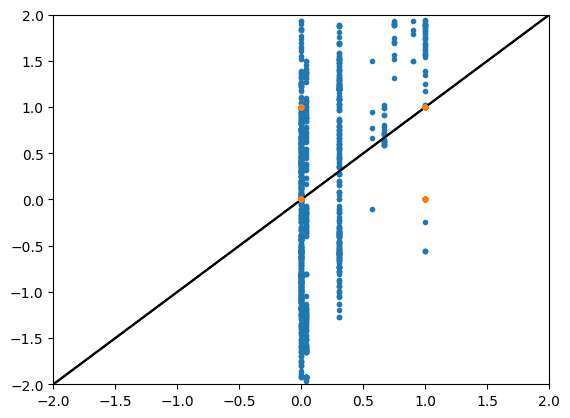

In [121]:
def validate_agains_ivs(*, model, ivs_x, ivs_y, metrics):
    y_pred = model.predict(ivs_x)
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.axline((0, 0), slope=1, color="black")
    plt.plot(y_pred, ivs_y, ".")
    
    return {metric_name: metric_f(ivs_y, y_pred) for (metric_name, metric_f) in metrics.items()}


print("--- Regressor ---")
print(f"Model: {best_regressor['name']}")
performance_on_ivs = validate_agains_ivs(model=best_regressor["model"], ivs_x=ivs_x_scaled, ivs_y=ivs_y_scaled, metrics={"mae": mean_absolute_error, "rve": explained_variance_score})
print(f"Performance on IVS: {performance_on_ivs}")
print(f"MAE (re-scaled): {performance_on_ivs['mae'] * y_std} ")
print(f"RVE: {performance_on_ivs['rve']}")
print()
print("--- Classifier ---")
print(f"Model: {best_classifier['name']}")
performance_on_ivs = validate_agains_ivs(model=best_classifier["model"], ivs_x=ivs_x_scaled, ivs_y=ivs_y, metrics={"acc": accuracy_score, "f1": f1_score, "recall": recall_score, "precision": precision_score})
print(f"Performance on IVS: {performance_on_ivs}")
print(f"Accuracy: {performance_on_ivs['acc']}")
print(f"F1: {performance_on_ivs['f1']}")
print(f"Precision: {performance_on_ivs['precision']}")
print(f"Recall: {performance_on_ivs['recall']}")
# TODO fix plots